# Exploratory Analysis of Parsed Data

<a id="table-of-contents"></a>

## Table of Contents

This notebook is organized into checks and explorations that will inform data cleaning.

0. [**Intro**](#intro)
   * Overview
   * Set configurations
   * Load data

1. [**High-Level Checks**](#data_checks)  
   * Record counts vs. expectations  
   * Date field validation  
   * Time distribution visualization  

2. [**Repeated Headlines**](#headlines)  
   * Most frequently occurring headlines  
   * Headlines with moderate repetition  

3. [**Duplicate and Near-Duplicate Articles**](#duplicates)  
   * Exact duplicates  
   * Near-duplicate titles  
   * Near-duplicate articles (identical standardized title, similar body text)  

4. [**Potential Issues**](#issues)  
   * Review of working-class keyword coverage  
   * Data profiling summary  

__To do:__

* Clarifications to new questions around stop words

* see "temp" / "to do" / "todo" items and finalize.

* Add Burui's analysis, and add Guo's to next notebook

* Peer review of notebook

<a id="itro"></a>

## 0. Intro


[⬆ Return to Top](#table-of-contents)

### Overview

This notebook investigates the parsed dataset to:

* **Validate parsing accuracy** – confirm that the parsing process worked as intended, or identify issues that require correction.  
* **Inform data cleaning steps** – understand the dataset's structure and characteristics to guide data cleaning steps before downstream analysis.

### Set configurations

Toggle example display in output cells.
* True  = Show example articles (helpful for decision-making phase)
* False = Hide examples (cleaner view for high-level review)

In [1]:
SHOW_EXAMPLE_ARTICLES = False

### Load packages and data

In [2]:
import sys
import os
import pandas as pd
from ftfy import fix_text
import re
import time
import pickle
from collections import Counter
import matplotlib.pyplot as plt
import calendar
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

In [3]:
# Add parent directory to sys.path to import local scripts
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(os.getcwd()))))

from data_preparation.utils import standardize_text, obtain_similarity_dictionary, create_date_components, add_duplicate_flags

In [4]:
df_articles = pd.read_pickle("../data/processed/parsed_articles.pkl")

<a id="data_checks"></a>
## 1. High Level Checks 


[⬆ Return to Top](#table-of-contents)

This section performs high-level checks on the dataset to ensure fundamental data quality and validity.

### Record Counts

In [5]:
expected_n_articles = 500 * 86 + 305 + 361
parsed_articles = df_articles.shape[0]

In [6]:
try:
    assert expected_n_articles == parsed_articles, (
        f"Mismatch: expected {expected_n_articles}, got {parsed_articles}"
    )
    print(f"✅ Total number of articles parsed: {parsed_articles} — matches expectations.")
except AssertionError as e:
    print(f"❌ There's a mismatch. {e}")


✅ Total number of articles parsed: 43666 — matches expectations.


In [7]:
expected_n_source_files = 88
parsed_sources_files = len(set(df_articles["source_file"]))

In [8]:
try:
    assert expected_n_source_files == parsed_sources_files, (
        f"Mismatch: expected {expected_n_source_files}, got {parsed_sources_files}"
    )
    print(f"✅ Total number of source files parsed: {parsed_sources_files} — matches expectations.")
except AssertionError as e:
    print(f"❌ There's a mismatch. {e}")


✅ Total number of source files parsed: 88 — matches expectations.


### Check dates

In [9]:
# Check that no date values are missing
missing_dates_count = df_articles['date'].isna().sum()
try:
    assert missing_dates_count == 0, (
        f"Found {missing_dates_count} articles with missing dates:\n"
        f"{df_articles.loc[df_articles['date'].isna()]}"
    )
    print("✅ All articles have a date — expectations met.")
except AssertionError as e:
    print(f"❌ Date check failed. {e}")


✅ All articles have a date — expectations met.


In [10]:
# Validate that all 'date' entries can be parsed into valid dates
try:
    parsed_dates = pd.to_datetime(df_articles["date"], errors="coerce").dt.date
    invalid_dates = df_articles.loc[parsed_dates.isna()]
    invalid_count = invalid_dates.shape[0]

    assert invalid_count == 0, (
        f"Found {invalid_count} articles with invalid or missing dates:\n"
        f"{invalid_dates}"
    )

    print("✅ All articles have valid dates — expectations met.")
except AssertionError as e:
    print(f"❌ Date validation failed. {e}")


✅ All articles have valid dates — expectations met.


In [11]:
print("Number of articles with date at the end: ", 
int(df_articles.apply(lambda x: x['correction_appended'] or x['load_date_at_end'], axis = 1).sum()))

Number of articles with date at the end:  461


### Time Distribution Plot

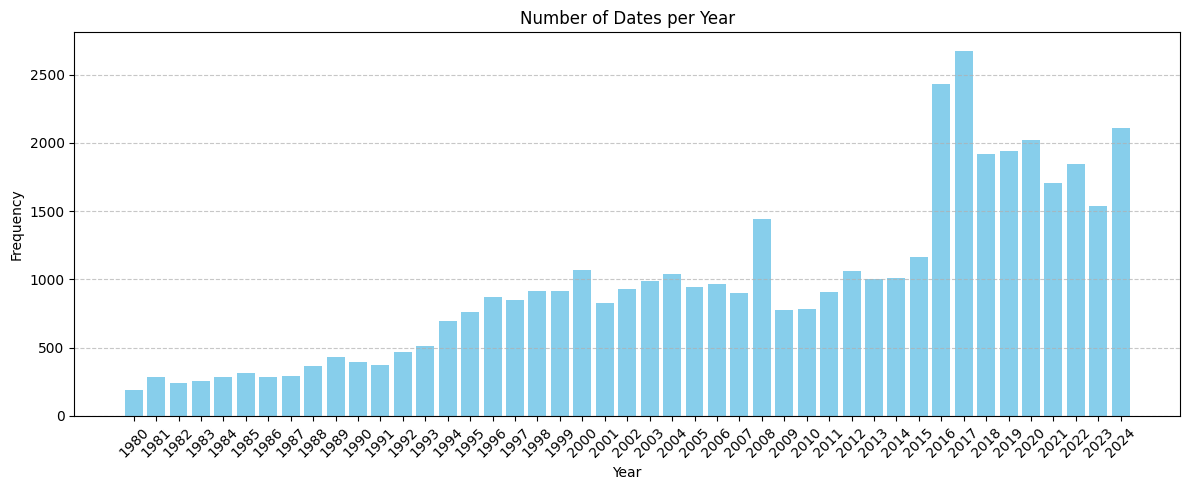

In [12]:
# Group by year
years = [d.year for d in parsed_dates]
year_counts = Counter(years)

# Sort by year
sorted_years = sorted(year_counts)
frequencies = [year_counts[year] for year in sorted_years]

# Plot
plt.figure(figsize=(12, 5))
plt.bar(sorted_years, frequencies, color='skyblue')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Number of Dates per Year')
plt.xticks(sorted_years, rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

<a id="headlines"></a>
## 2. Recurring Headlines

[⬆ Return to Top](#table-of-contents)

This section examines headlines that appear repeatedly in the dataset to identify patterns that may require attention. It is divided into two categories: __most frequent headlines__ and __medium-frequency headlines__.

For each recurring headline, we manually review a sample to identify underlying patterns and decide on appropriate data-cleaning actions. Although we apply the same review process to both categories, we present them separately because they tend to exhibit distinct patterns.


### Most frequent headlines

In [13]:
highest_frequency_titles = {key:int(value) for key, value in dict(df_articles['title'].value_counts()).items() if value > 110}
highest_frequency_titles

{'No Headline In Original': 368}

In [14]:
df_no_headline = df_articles.loc[df_articles["title"] == "No Headline In Original"]
df_no_headline.head(2)

,title,publisher,date,section,length,body,correction_appended,load_date_at_end,source_file
446,No Headline In Original,The New York Times,2024-09-01,Section MB; Column 0; Metropolitan Desk; Pg. 3...,533 words,"\n\nIn the Schools: Dress Codes, Self-Expressi...",False,False,NYT/55.DOCX
457,No Headline In Original,The New York Times,2022-01-30,Section MB; Column 0; Metropolitan Desk; Pg. 3...,774 words,"\n\nHow Fire Defined the Bronx, and Us\nReader...",False,False,NYT/55.DOCX


In [15]:
select_index = 0 # change index to view the body of a different article
if SHOW_EXAMPLE_ARTICLES:
    print(df_no_headline['body'].iloc[select_index])

In [16]:
# Example from other publishers
select_index = 0 # change index to view the body of a different article
select_publisher = "Chicago Daily Herald" # change publisher name to view a different example
if SHOW_EXAMPLE_ARTICLES:
    df_no_headline_select_publisher = df_no_headline.loc[df_no_headline["publisher"] == "Chicago Daily Herald"]
    print(df_no_headline_select_publisher['body'].iloc[select_index])

__Observation:__ A manual review of a sample of articles titled "No Headline In Original" reveals that the original source data contains this exact title, confirming it is not a parsing error. In most cases, the article body consists of multiple readers’ notes to the editor, each with its own heading; however, there are exceptions to this pattern.

__Decision:__ During data cleaning, separate readers’ notes to the editor from the main dataset to enable independent analysis.


### Medium-frequency headlines

In [17]:
# Repeated titles
{key: int(value) for key, value in dict(df_articles["title"].value_counts()).items() if value > 20 and value < 115}

{'Movie guide': 101,
 'Movie Guide': 36,
 'New & Noteworthy Paperbacks': 36,
 'Letters to the Editor': 34,
 'MOVIE GUIDE': 33,
 'Paperback Row': 30,
 'inside track': 28,
 'Art': 27,
 'Readers Write': 27,
 'Four stars: superior. Three stars: good. Two stars: average. One star: poor. D (': 25,
 'Marco Rubio; REPUBLICAN': 24}

In [18]:
select_title = "MOVIE GUIDE" # select title
select_index = 0 # select index
if SHOW_EXAMPLE_ARTICLES:
    print(df_articles.loc[df_articles["title"] == select_title]["body"].iloc[select_index])

__Observation:__ We manually reviewed a selection of articles for each frequently repeated title and found that they fell into two main groups:

1. Not relevant for our analysis: These articles typically consist of recurring lists or recommendations related to movies, books, and the arts, accompanied by only brief descriptions. Given the limited depth of information, we determined they do not meet the requirements for our analysis.

    __Decision__: Filter out these articles.

    __Applies to__: Articles with titles "New & Noteworthy Paperbacks", "Paperback Row", "Art", "Four stars: superior. Three stars: good. Two stars: average. One star: poor. D (", "Movie guide", "MOVIE GUIDE".


2. Readers’ notes to the editor: These articles, including Letters to the Editor and Readers Write, document conversations between readers and the publication. While not all are directly related to the working class, the presence of at least one working-class keyword in a set of reader responses qualified the entire set for inclusion.

    __Decision:__ Keep these articles, but store them separately from the main dataset for independent study.

    __Applies to:__ Articles titled 'Letters to the Editor' and "Readers Write"

<a id="duplicates"></a>

## 3. Duplicates and Near-Dupplicates

[⬆ Return to Top](#table-of-contents)

This section examines exact duplicates and near-duplicates in the dataset.

We begin by **cleaning the text data** and **removing exact duplicates**, recording the number of dropped rows.

Next, we analyze **similarity scores for titles** to explore opportunities for further standardization.  
> *Note:* The *standardized title* field is used only for grouping articles in the next stage. We do **not** deduplicate based on standardized title alone. Deduplication requires considering both title and body content.

We then analyze **similarity scores for article bodies** within each group of matching standardized titles. Three thresholds are tested—**90%**, **95%**, and **98%**—to determine the most appropriate cutoff for identifying near-duplicates.

Final deduplication is performed when:  
1. The standardized titles match, **and**  
2. The body similarity score meets or exceeds the chosen threshold.

### Clean-text data and remove exact duplicates

In [19]:
# clean data
df_articles['body'] = df_articles['body'].apply(fix_text)
df_articles['title'] = df_articles['title'].apply(fix_text)

# standardize titles
df_articles['title_stand'] = df_articles['title'].apply(standardize_text)

In [20]:
# 1. Shuffle the DataFrame
df_articles = df_articles.sample(frac=1, random_state=42).reset_index(drop=True)

# 2. Deduplicate while keeping earliest date 
before_n = df_articles.shape[0]
df_articles = (
    df_articles
    .sort_values(by='date', ascending=True)
    .drop_duplicates(subset=["body", "title_stand"], keep='first')
)

after_n = df_articles.shape[0]

# 3. Sort final DataFrame by date from latest to earliest
df_articles = df_articles.sort_values(by='date', ascending=False).reset_index(drop=True)

print(f"Number of dropped duplicates: {before_n - after_n}.")

Number of dropped duplicates: 314.


__Decision:__

* Keep original date when deduplicating.

### Analyzing similarity scores for non-identical titles

In [ ]:
similar_dict_path = "../data/processed/similar_dict_75.pkl"

if os.path.exists(similar_dict_path):
    # Load dictionary from pickle file
    with open(similar_dict_path, "rb") as f:
        similar_dict = pickle.load(f)
else:   
    threshold = .75
    titles = list(set(df_articles['title_stand']))
    print(f"Start similarity comparison with {threshold} threshold.")
    start_time = time.time()
    similar_dict = obtain_similarity_dictionary(titles, threshold)
    end_time = time.time()
    print(f"Elapsed time: {(end_time - start_time) / 60:.4f} minutes")
    
    # Save dictionary to a pickle file
    with open(similar_dict_path, "wb") as f:
        pickle.dump(similar_dict, f)

Start similarity comparison with 0.75 threshold.


In [ ]:
stand_text1 = list(similar_dict.keys())[0]
title1 = df_articles.loc[df_articles['title_stand'] == stand_text1]['title'].iloc[0]

stand_text2 = similar_dict[list(similar_dict.keys())[0]][0][0]
title2 = df_articles.loc[df_articles['title_stand'] == stand_text2]['title'].iloc[0]

print(f"Matching headlines example:\n\t{title1}\n\t{title2}")
print(f"\nStandardized versions:\n\t{stand_text1}\n\t{stand_text2}")
print("\nSimilarity score: ", similar_dict[list(similar_dict.keys())[0]][0][1])

In [ ]:
key, value = list(similar_dict.items())[0]
word_differences = [" ".join(set(key.split(" ")) - set(set(value[0][0].split(" ")))) for key,value in similar_dict.items()]
word_diff_count = Counter(word_differences)

In [ ]:
# most frequent words resulting in differences
{key: value for key, value in word_diff_count.items() if value > 10 and key != ""}

__Observation:__

* When comparing similar titles, the most common differences are due to the above words, plus dates.


__Suggestion:__ (to confirm with Elena)

* Remove stop words from titles for title-body near-duplicate comparison. (see next section for a comparison with earlier standardized titles)



In [ ]:
# obtain title-specific stop words
word_diff_count = {key.strip(" "): value for key, value in word_diff_count.items() if value > 10 and key != ""}
title_stop_words = [i.split(" ") for i in word_diff_count.keys()]
title_stop_words = list(set([item for sublist in title_stop_words for item in sublist])) # flatten list
# add date compoenets
title_stop_words += create_date_components()

In [ ]:
# save stop words for cleaning stage
with open("../data_preparation/title_stop_words.pkl", "wb") as f:
    pickle.dump(title_stop_words, f)

In [ ]:
# refine title standardization based on stop words
df_articles['title_stand_afterStopWords'] = df_articles['title'].apply(lambda x: standardize_text(x, title_stop_words))

### Analyzing similarity scores for bodies with the same title

In [ ]:
import time

temp_file_path = "../data/processed/parsed_articles_with_nearDup_indicator_beforeStopWords.pkl"
if os.path.exists(temp_file_path):
    df_articles = pd.read_pickle(temp_file_path)
else:
    start_time = time.time()

    thresholds = [0.90, 0.95, 0.98]
    df_articles = add_duplicate_flags(df_articles, "title_stand", thresholds)

    end_time = time.time()
    print(f"Elapsed time: {(end_time - start_time) / 60:.4f} minutes")
    
    df_articles.to_pickle(temp_file_path)

In [ ]:
# change in title_stand (removed stop words) #to do: change back to original heading.
print("Number of near-duplicates before removing Stop Word from title")
print(f"\tAt 90% threshold: {df_articles['is_near_duplicate_90'].sum()}")
print(f"\tAt 95% threshold: {df_articles['is_near_duplicate_95'].sum()}")
print(f"\tAt 98% threshold: {df_articles['is_near_duplicate_98'].sum()}")

In [ ]:
# temp

# Subset of columns to rename
cols_to_rename = ['is_near_duplicate_90', 'is_near_duplicate_95',  'is_near_duplicate_98',
                 'duplicate_of_index_90', 'duplicate_of_index_95', 'duplicate_of_index_98']

# Create a rename mapping
rename_mapping = {col: f"{col}_beforeStopWords" for col in cols_to_rename}

# Rename columns
df_articles = df_articles.rename(columns=rename_mapping)


In [ ]:
import time

temp_file_path = "../data/processed/parsed_articles_with_nearDup_indicator_afterStopWords.pkl" #to do: rename variable
if os.path.exists(temp_file_path):
    df_articles = pd.read_pickle(temp_file_path)
else:
    start_time = time.time()

    thresholds = [0.90, 0.95, 0.98]
    df_articles = add_duplicate_flags(df_articles, 'title_stand_afterStopWords', thresholds)

    end_time = time.time()
    print(f"Elapsed time: {(end_time - start_time) / 60:.4f} minutes")
    
    df_articles.to_pickle(temp_file_path)

In [ ]:
print("Number of near-duplicates after removing Stop Words from title")
print(f"\tAt 90% threshold: {df_articles['is_near_duplicate_90'].sum()}")
print(f"\tAt 95% threshold: {df_articles['is_near_duplicate_95'].sum()}")
print(f"\tAt 98% threshold: {df_articles['is_near_duplicate_98'].sum()}")

In [ ]:
# temp
# Subset of columns to rename
cols_to_rename = ['is_near_duplicate_90', 'is_near_duplicate_95',  'is_near_duplicate_98',
                 'duplicate_of_index_90', 'duplicate_of_index_95', 'duplicate_of_index_98']

# Create a rename mapping
rename_mapping = {col: f"{col}_afterStopWords" for col in cols_to_rename}

# Rename columns
df_articles = df_articles.rename(columns=rename_mapping)

In [ ]:
# todo: adjust back after confirmations
cols =  [col for col in df_articles.columns if col not in ['title_stand', 'title_stand_afterStopWords']] + ['title_stand', 'title_stand_afterStopWords']
df_articles = df_articles[cols]

In [ ]:
# temp
df_articles.to_pickle("../data/processed/parsed_articles_with_nearDup_indicator_comparison.pkl")

In [ ]:
df_articles.head()

In [ ]:
df_dup_range1 = df_articles.loc[df_articles['is_near_duplicate_90'] & ~df_articles['is_near_duplicate_95']]
df_dup_range1.head()

In [44]:
idx_for_comparison = [103, 486]
#idx_for_comparison = [1114, 1188]
#idx_for_comparison = [997, 1019]
#idx_for_comparison = [2578, 2581]
df_articles.iloc[idx_for_comparison]
text1 = df_articles.iloc[idx_for_comparison[0]]['body']
text2 = df_articles.iloc[idx_for_comparison[1]]['body']
print(compute_similarity(text1, text2))

0.9780122811088866


In [ ]:
if SHOW_EXAMPLE_ARTICLES:
    print(text1)

In [ ]:
if SHOW_EXAMPLE_ARTICLES:
    print(text2)

**Observation:**  
After manually reviewing sample cases across thresholds, we found the 90% similarity threshold to be the most appropriate. For articles scoring between 90% and 95%, differences typically stem from extra information at the end, such as graphic descriptions or load dates.  

**Decision:**  
- Use a 90% similarity threshold.  
- When removing near-duplicates, retain the longer version.  

<a id="issues"></a>
## 4. Potential Issues


[⬆ Return to Top](#table-of-contents)

This section reviews sources of potential issues with the parsing script.

### Missing "working class" keywords

In [ ]:
df_missing_working_class = df_articles[[('working-class' not in str(i).lower()) and ('working class' not in str(i).lower()) and ('(working) class' not in str(i).lower()) for i in df_articles['body_clean']]]
df_missing_working_class = df_missing_working_class[[('working-class' not in str(i).lower()) and ('working class' not in str(i).lower()) for i in df_missing_working_class['title']]]

In [ ]:
# percetnage time missing
fraction_missing = (df_missing_working_class.shape[0]) / df_articles.shape[0]
if fraction_missing > 0:
    print("{}% of articles don't include the working class keyworks.".format(round(fraction_missing*100,2)))

In [ ]:
df_missing_working_class.head()

__Observation:__ A manual review of a sample of articles confirmed that “working-class” keywords appear in the raw data outside the article title and body. This is not a parsing or data extraction issue. While some articles are relevant, many are not.

__Decision:__ Retain articles for now, pending further analysis.

### Patterns in titles

Add @Burui's analysis, looking into articles starting with "Best Sellers:" or other "xxx: yyy" pattern.

**Observation:** Articles with titles starting with "Best Sellers:" or "Four Stars:" contain general lists and recommendations.  

**Decision:** Exclude articles with titles starting with "Best Sellers:" or "Four Stars:", consistent with the earlier decision to remove recurring lists and recommendation pieces.  


### Other Observations

**Observation:** The end of some articles contains extraneous information.  

**Decision:** Remove “load-date:” and any other dates appearing at the end of the article.  